1. 資料匯入、欄位名稱設定

In [36]:
import pandas as pd
import joblib\

from docx import Document
import matplotlib.pyplot as plt
from io import BytesIO

In [37]:

# 讀取csv檔案並設定欄位名稱
df = pd.read_csv('./data/一般_final.csv') #讀取csv檔案
df


,user_id,user_intro,user_birthday,user_gender,user_nickname,user_domicile,user_residence,user_education,user_basic_info_score,user_headphoto_yn,...,post_act_at,post_act_with,post_act_feel,post_act_at_with_feel_num,post_act_at_with_feel_ratio,post_avg_like,post_avg_comment,post_avg_share,post_recent_yn,class
0,100001295492783,0,0,0,0,1,1,0,2,1,...,0,0,1,1.0,0.10,102.00,30.60,0.2,1.0,1
1,100010248991136,0,0,1,0,1,1,1,4,1,...,0,0,0,0.0,0.00,34.50,5.17,0.0,0.0,1
2,100006328689618,0,0,1,1,0,0,1,3,1,...,0,0,0,0.0,0.00,82.70,7.30,0.1,0.0,1
3,100008068359835,0,0,1,1,0,0,0,2,1,...,1,0,0,1.0,0.13,8.89,1.00,0.0,0.0,1
4,100003713563611,1,0,1,0,1,1,0,4,1,...,0,0,0,0.0,0.00,8.00,1.00,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,100086922620200,1,0,0,0,1,1,1,4,1,...,0,0,0,0.0,0.00,0.00,0.00,0.0,0.0,0
1702,100004713883805,0,0,1,1,1,1,0,4,1,...,0,0,0,0.0,NaN,0.60,0.10,0.0,1.0,0
1703,100086731131902,1,0,0,0,1,1,1,4,1,...,0,0,0,0.0,0.00,0.00,0.00,0.0,NaN,0
1704,100074856204493,1,0,0,0,1,1,1,4,1,...,0,0,0,0.0,0.00,0.50,0.50,0.0,0.0,0


Step 2 : 資料預處理

> 遺漏值處理


In [38]:
def impute_missing_by_group_distribution(df, group_col='class', output_path=None, verbose=True):
    """
    對 DataFrame 中的遺漏值，根據指定分組欄位的數據分佈進行機率差補。

    Args:
        df (pd.DataFrame): 需要處理遺漏值的 DataFrame。
        group_col (str): 用於分組的欄位名稱，預設為 'class'。
        output_path (str, optional): 若提供路徑，則將處理後的 DataFrame 儲存為 CSV。
                                     預設為 None (不儲存)。
        verbose (bool): 是否印出處理前後的遺漏值資訊。預設為 True。

    Returns:
        pd.DataFrame: 遺漏值已被填補的 DataFrame。
    """
    df_imputed = df.copy() # 創建副本以避免修改原始 DataFrame

    if verbose:
        print("--- 處理前 ---")
        missing_samples_before = df_imputed.isnull().any(axis=1).sum()
        print(f"含有遺漏值的樣本數：{missing_samples_before}")
        cols_with_missing_before = df_imputed.columns[df_imputed.isnull().any()]
        if not cols_with_missing_before.empty:
            print(f"含有遺漏值的欄位：{cols_with_missing_before.tolist()}")
        else:
            print("沒有欄位含有遺漏值。")
        print("-" * 20)

    # 找出需要插補的欄位
    cols_to_impute = df_imputed.columns[df_imputed.isnull().any()]

    if cols_to_impute.empty:
        print("無需進行遺漏值遞補。")
        if output_path:
             df_imputed.to_csv(output_path, index=False, encoding='utf-8-sig')
             print(f"原始 DataFrame 已儲存至：{output_path}")
        return df_imputed

    # --- 機率分佈差補法函式 (內部定義或保持外部亦可) ---
    def _fillna_by_distribution(series):
        """根據 Series 中非空值的機率分佈填補空值"""
        null_mask = series.isnull()
        null_count = null_mask.sum()

        if null_count > 0:
            # 計算非遺漏值的機率分佈
            probabilities = series.dropna().value_counts(normalize=True)
            # 如果 dropna() 後為空 (例如某組內該欄位全是 NaN)，則無法進行機率差補
            if probabilities.empty:
                # 這裡可以選擇策略：保留 NaN、用眾數填充、或其他
                # 目前保留 NaN，因為無法從組內學習分佈
                 return series
            # 根據分佈隨機抽樣生成填補值
            fill_values = np.random.choice(probabilities.index, size=null_count, p=probabilities.values)
            # 填補遺漏值
            series[null_mask] = fill_values
        return series
    # --- 函式定義結束 ---

    # 根據 group_col 分組，並對需要插補的欄位應用差補函數
    grouped = df_imputed.groupby(group_col)
    for col in cols_to_impute:
        # 使用 transform 將結果對齊回原始 DataFrame 的索引
        df_imputed[col] = grouped[col].transform(_fillna_by_distribution)

    print('-'*8 + ' 遺漏值遞補執行完畢 ' + '-'*8)

    if verbose:
        print("--- 處理後 ---")
        missing_samples_after = df_imputed.isnull().any(axis=1).sum()
        print(f"含有遺漏值的樣本數：{missing_samples_after}")
        cols_with_missing_after = df_imputed.columns[df_imputed.isnull().any()]
        if not cols_with_missing_after.empty:
            print(f"含有遺漏值的欄位：{cols_with_missing_after.tolist()}")
        else:
             print("所有欄位的遺漏值均已處理完畢。")
        print("-" * 20)

    # 儲存結果 (如果指定了路徑)
    if output_path:
        df_imputed.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f"已將遞補後的 DataFrame 儲存至：{output_path}")

    return df_imputed

# --- 進行遺漏值填補 ---

imputed_df = impute_missing_by_group_distribution(
    df,
    group_col='class', # 指定分組欄位
    output_path='data/missing_data_imputation_file.csv', # 指定輸出路徑
    verbose=True # 顯示詳細資訊
)
print("\n處理後的 DataFrame:")
print(imputed_df)

--- 處理前 ---
含有遺漏值的樣本數：1609
含有遺漏值的欄位：['user_headphoto_gender_match', 'user_age_diff', 'post_share_ratio', 'post_photo_ratio', 'post_act_at_with_feel_num', 'post_act_at_with_feel_ratio', 'post_avg_like', 'post_avg_comment', 'post_avg_share', 'post_recent_yn']
--------------------
-------- 遺漏值遞補執行完畢 --------
--- 處理後 ---
含有遺漏值的樣本數：0
所有欄位的遺漏值均已處理完畢。
--------------------
已將遞補後的 DataFrame 儲存至：data/missing_data_imputation_file.csv

處理後的 DataFrame:
              user_id  user_intro  user_birthday  user_gender  user_nickname  \
0     100001295492783           0              0            0              0   
1     100010248991136           0              0            1              0   
2     100006328689618           0              0            1              1   
3     100008068359835           0              0            1              1   
4     100003713563611           1              0            1              0   
...               ...         ...            ...          ...            ...

3. 探索性分析

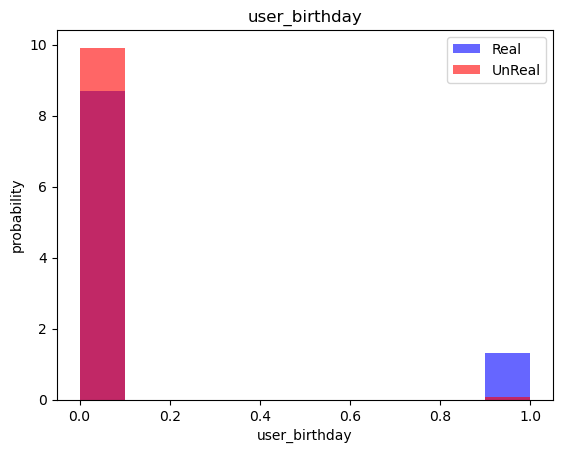

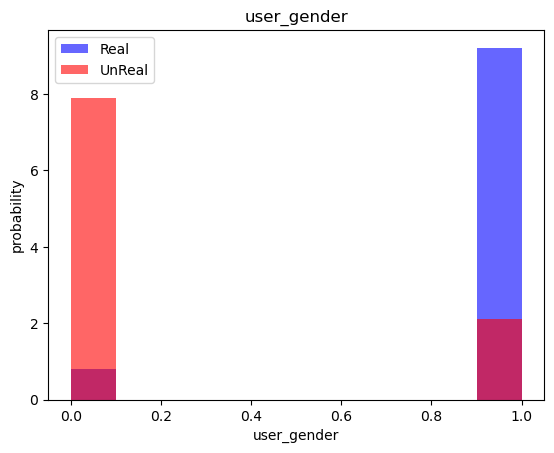

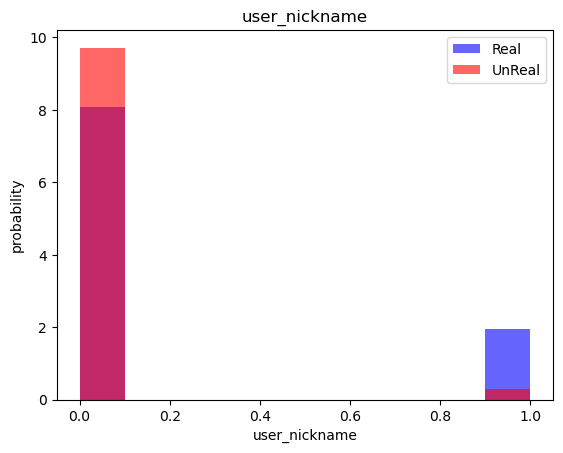

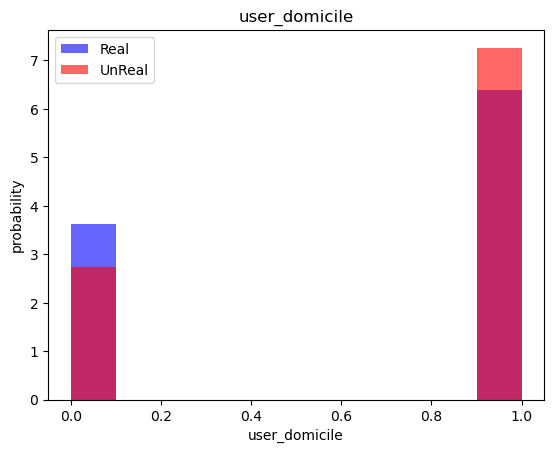

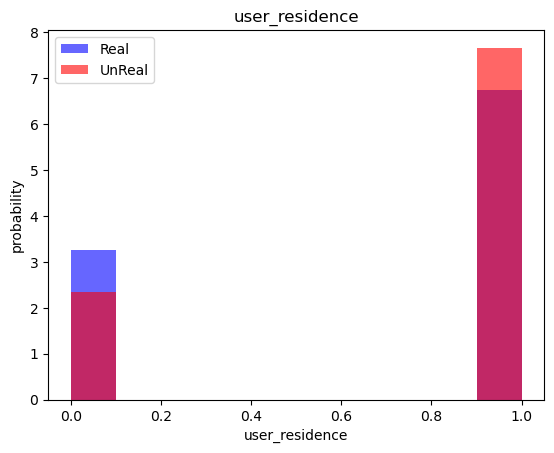

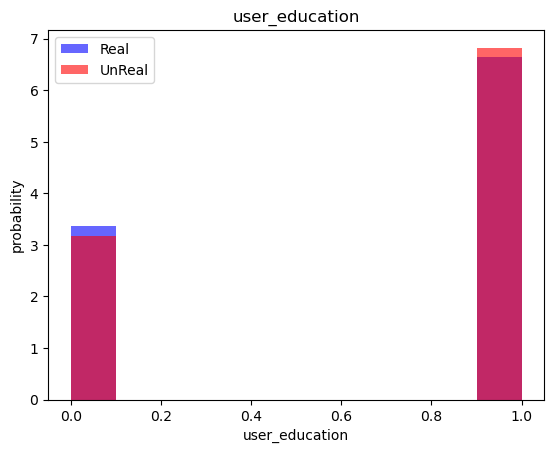

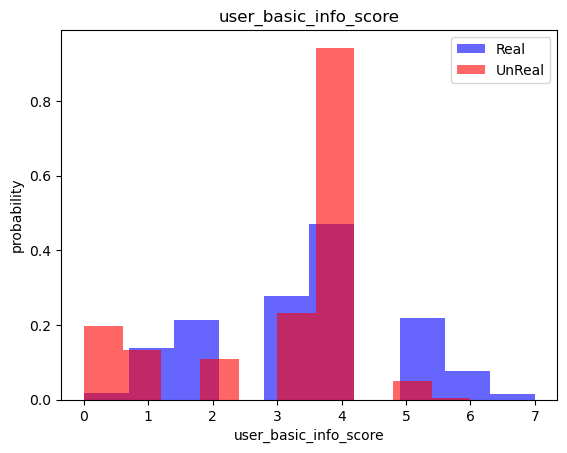

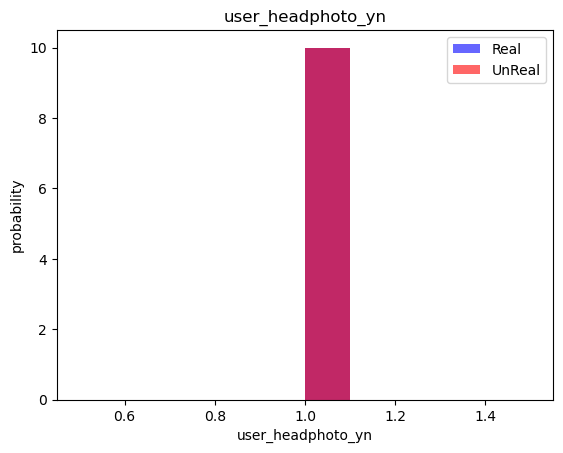

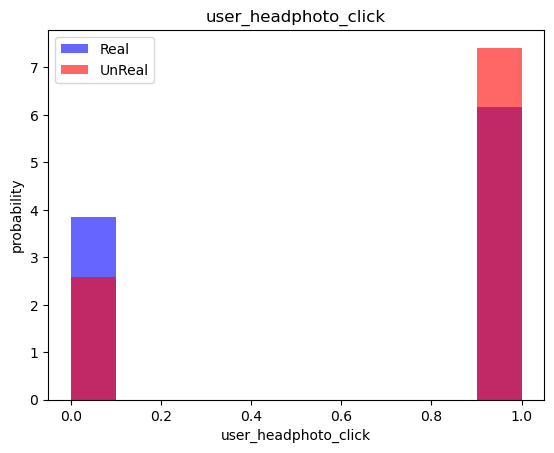

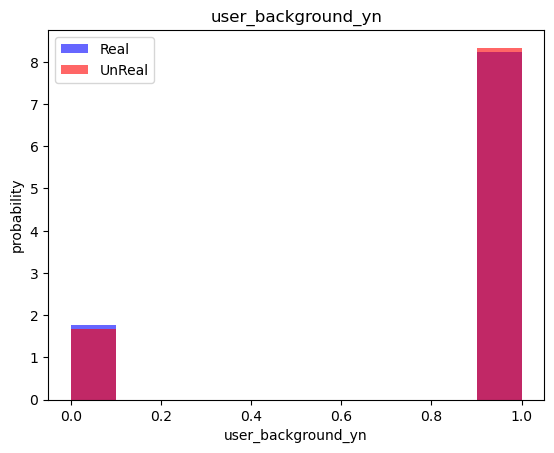

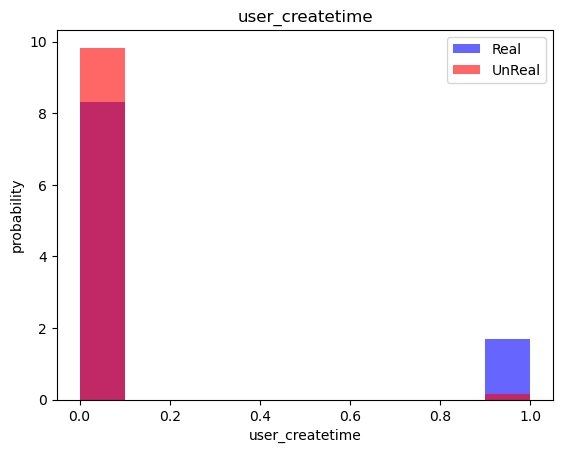

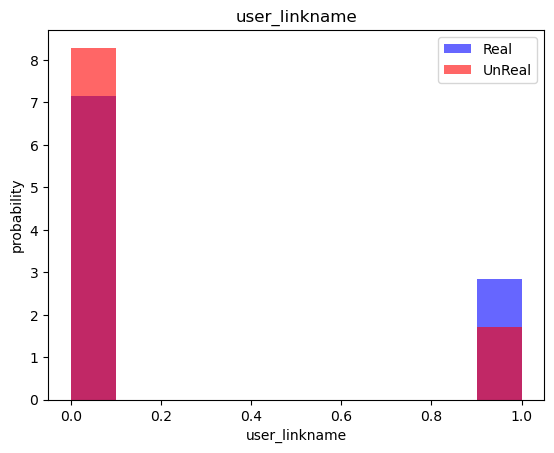

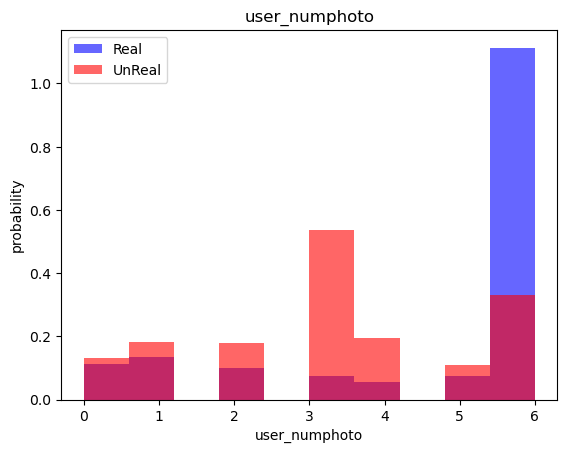

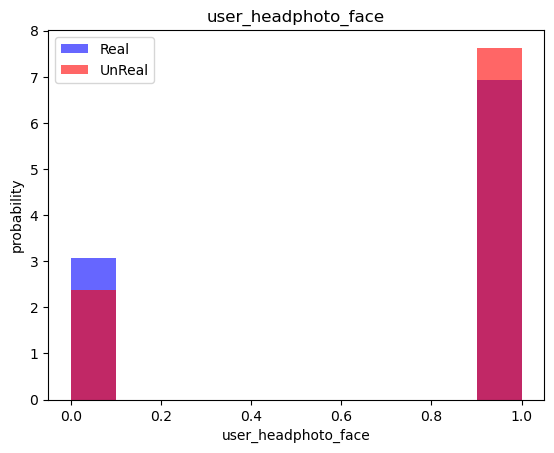

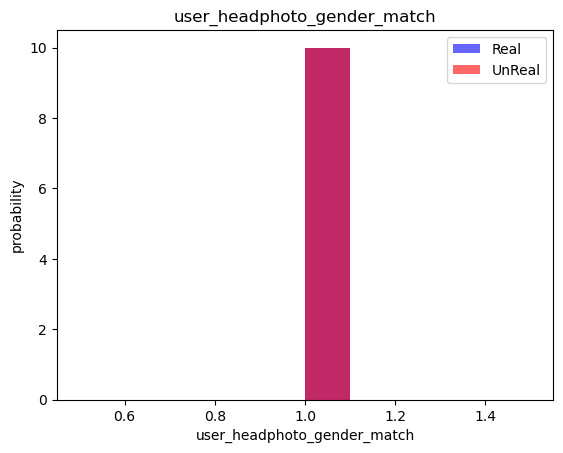

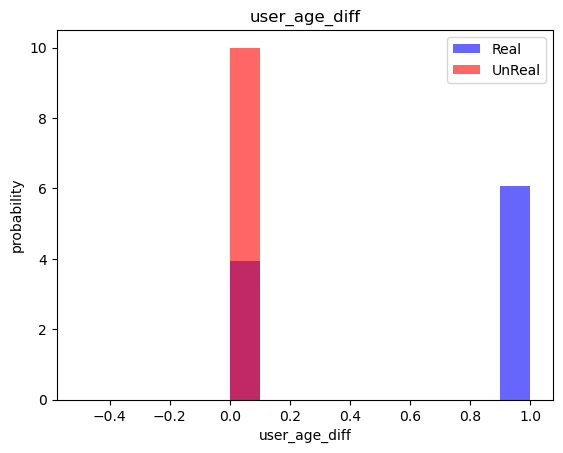

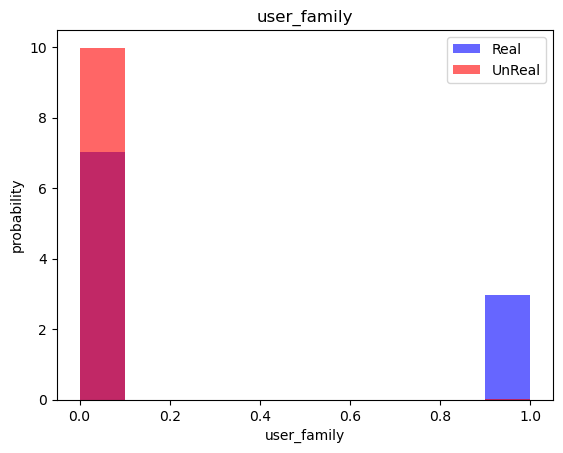

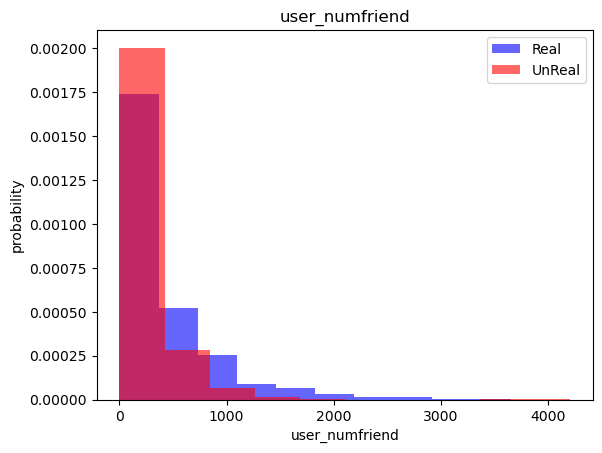

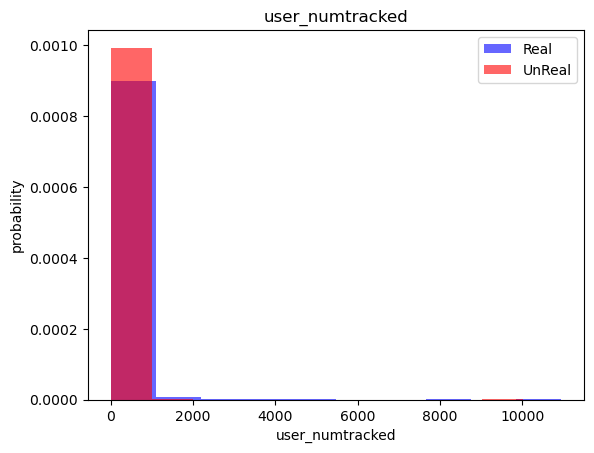

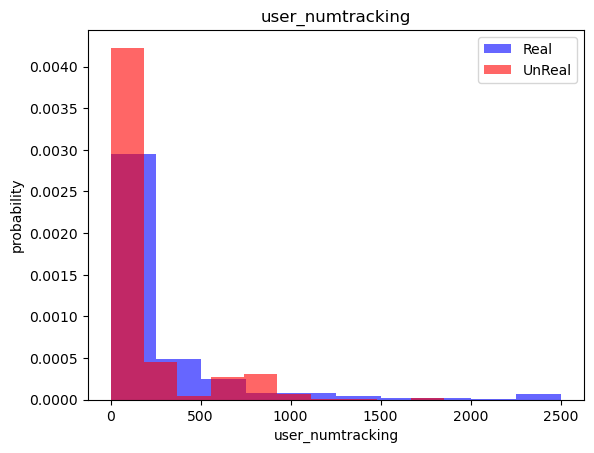

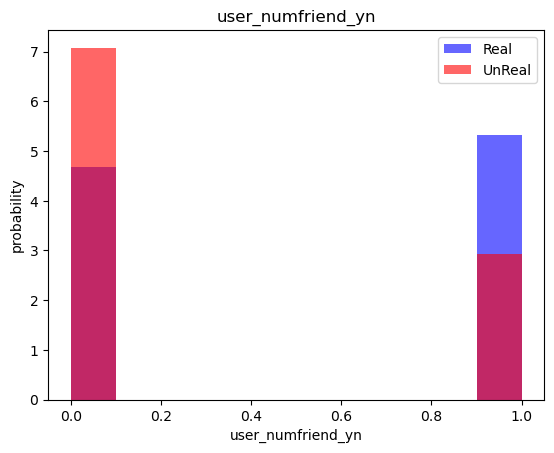

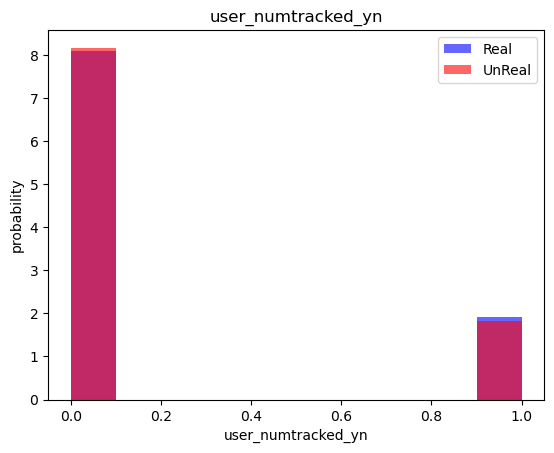

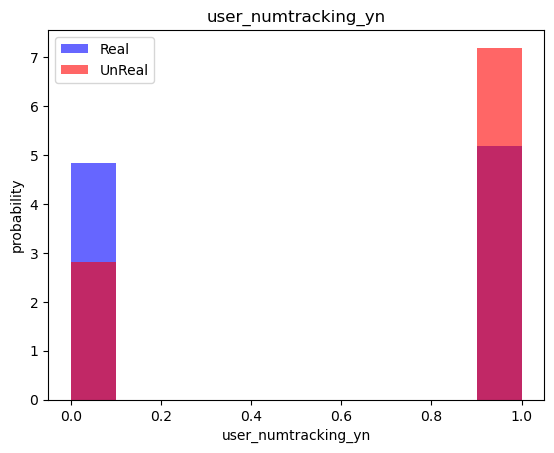

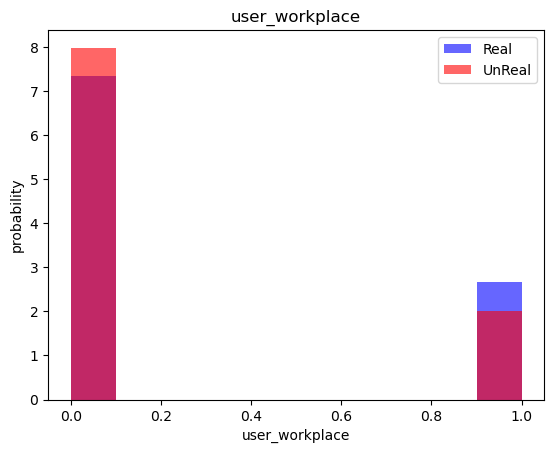

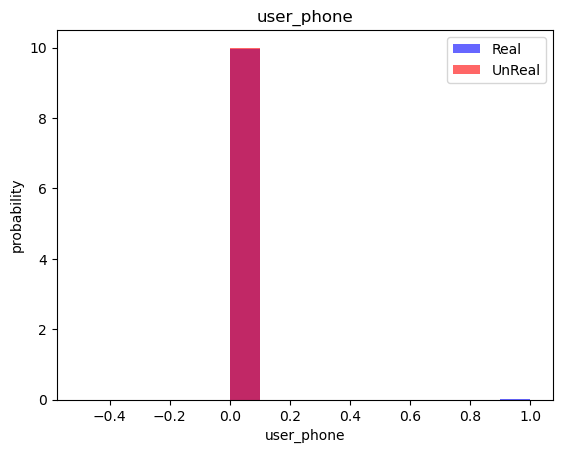

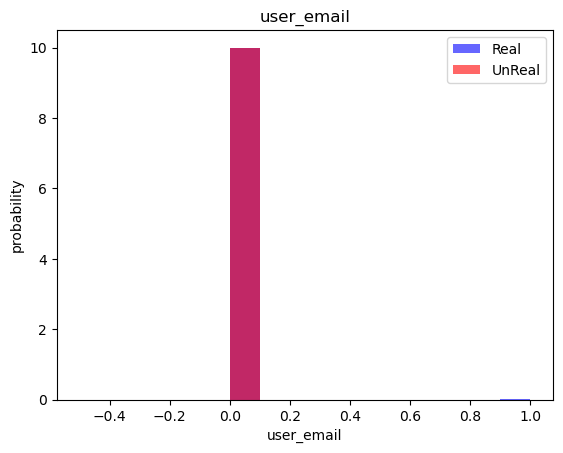

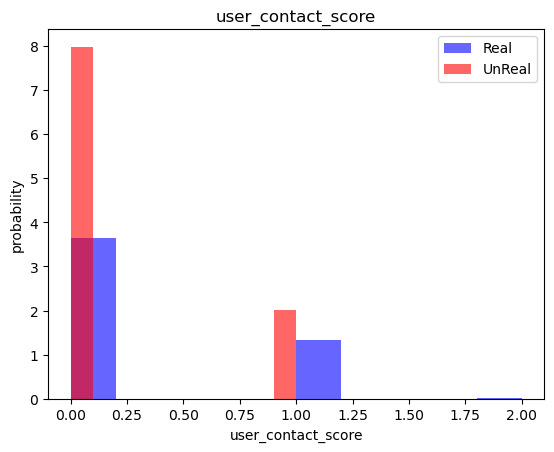

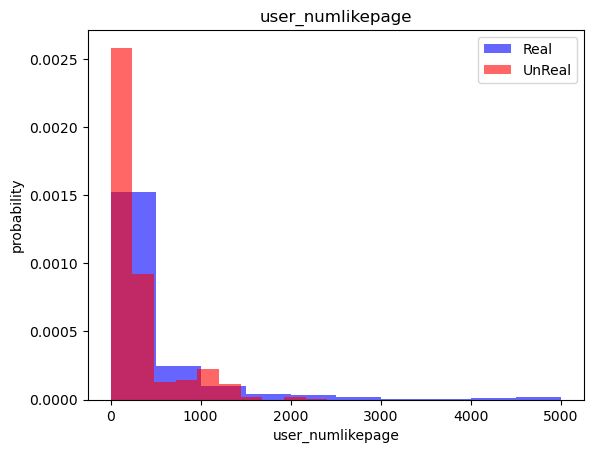

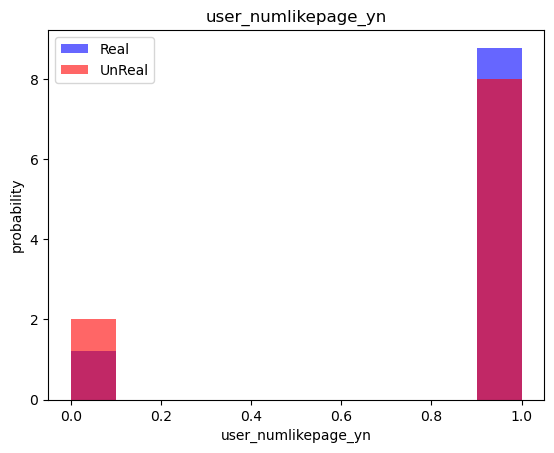

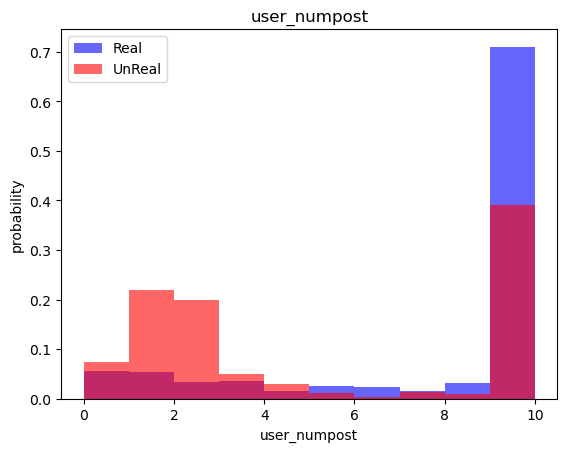

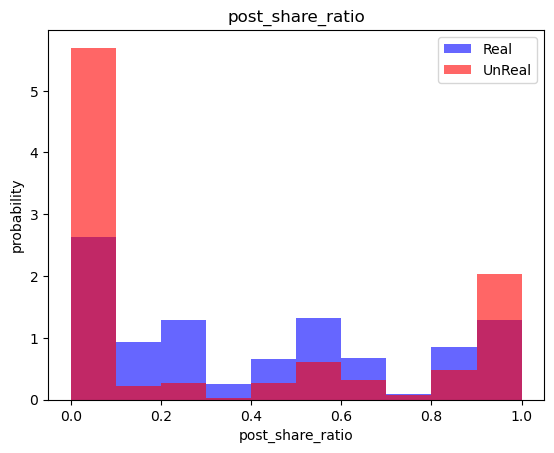

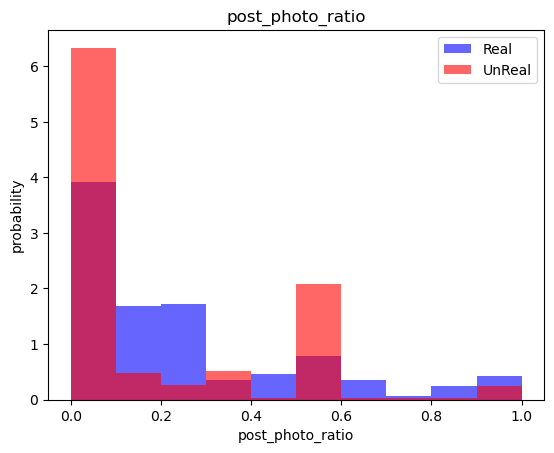

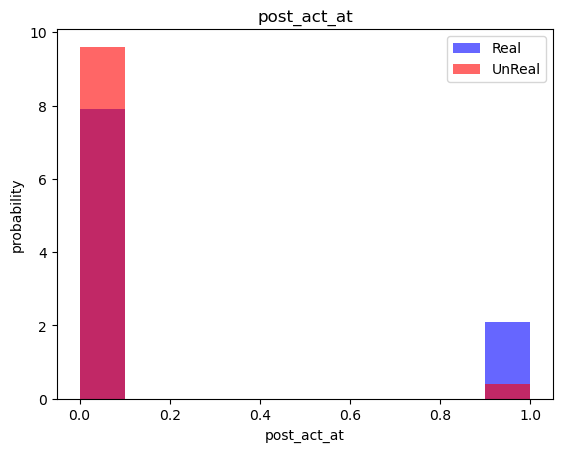

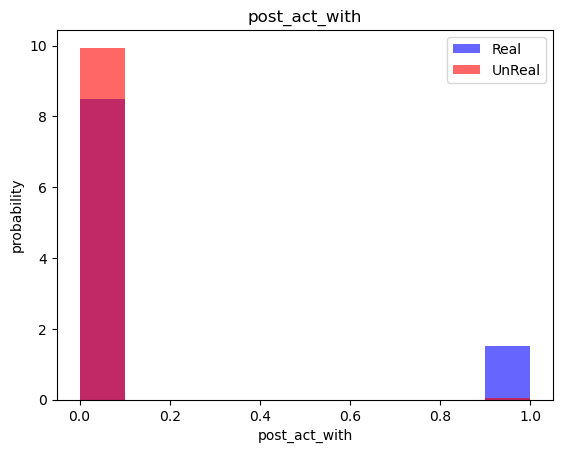

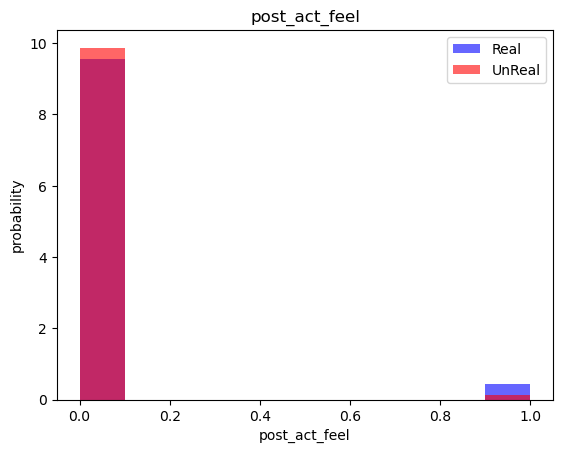

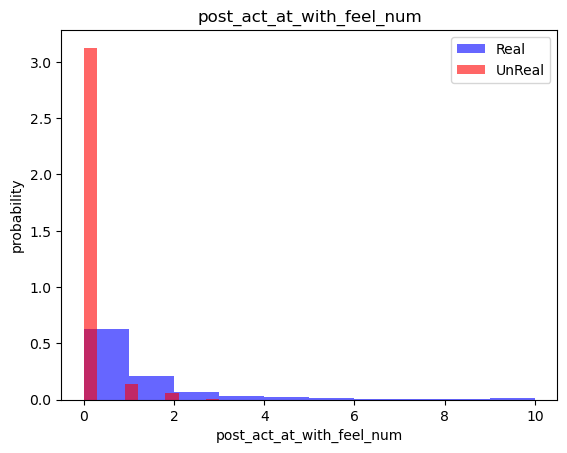

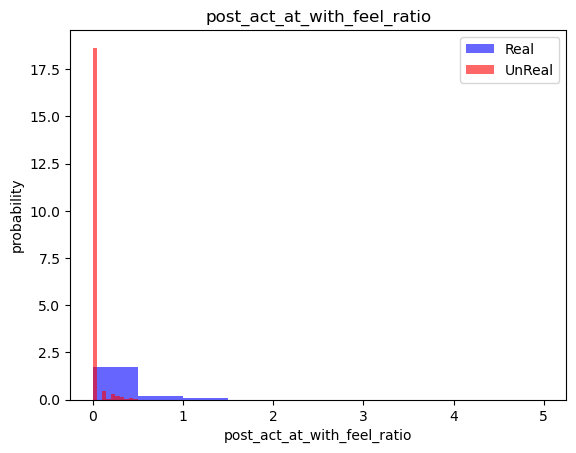

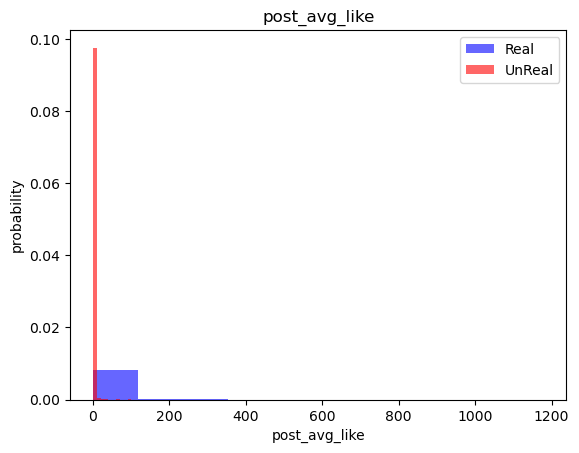

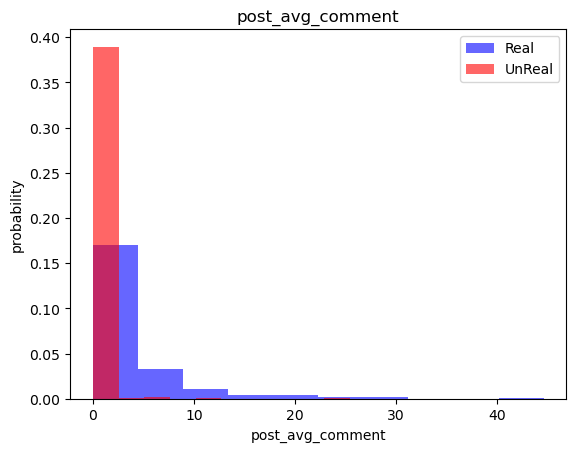

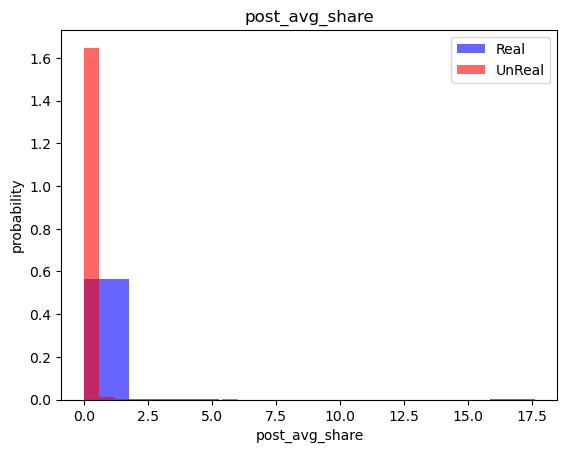

In [41]:
cols = imputed_df.columns.tolist()[1:-1]

doc = Document()
for label in cols[1:-1]:
  plt.figure()
  plt.hist(imputed_df[imputed_df['class']==1][label],color='blue',label='Real',alpha=0.6,density=True,align='mid')
  plt.hist(imputed_df[imputed_df['class']==0][label],color='red',label='UnReal',alpha=0.6,density=True,align='mid')
  plt.title(label)
  plt.ylabel('probability')
  plt.xlabel(label)
  plt.legend()
  plt.savefig("./image_output/"+label, format='png',dpi=300,bbox_inches='tight')

  # 將圖片儲存到BytesIO對象
  image_stream = BytesIO()
  plt.savefig(image_stream, format='png')
  plt.show()
  plt.close()

  # 將BytesIO對象中的圖片插入到Word文件中
  image_stream.seek(0)
  doc.add_picture(image_stream)
  doc.add_paragraph(f"Figure: {label}", style='Caption') # 新增圖標題

  # 新增分頁
  doc.add_page_break()

doc.save('./image_output/EDA_pic_distribution_output_no_missing.docx')


4. 模型訓練、測試與比較

In [42]:
# 載入必要的套件
# 樣本訓練語測試分類

from sklearn.model_selection import train_test_split
# 特徵轉化(Normalization)
from sklearn.preprocessing import MinMaxScaler

# 演算法模組
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

# 模型評估
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#圖繪製
import seaborn as sns

#時間計算
import time

In [44]:
df_used = imputed_df #選擇數據

X = df_used.iloc[:,1:-1]
y = df_used.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#特徵縮放
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


SVM(poly)分類報告：
               precision    recall  f1-score   support

           0       0.92      0.94      0.93       127
           1       0.97      0.95      0.96       215

    accuracy                           0.95       342
   macro avg       0.95      0.95      0.95       342
weighted avg       0.95      0.95      0.95       342

訓練時間: 0.017518997192382812 秒
預測時間: 0.002102375030517578 秒


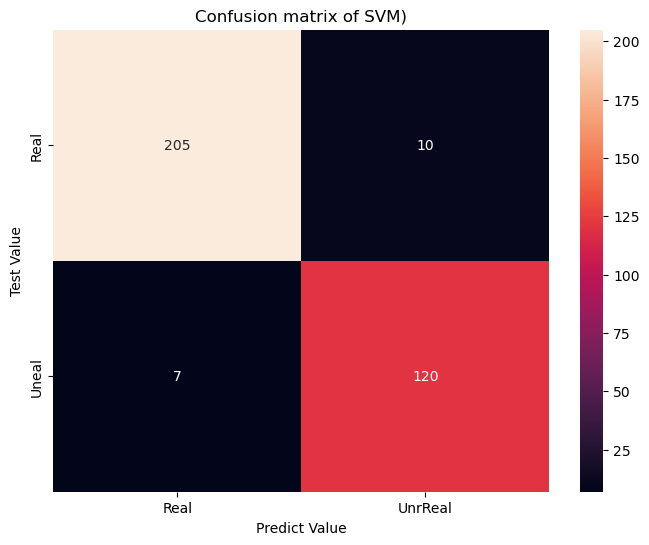

In [47]:
#初始化SVM模型
svm_model = SVC(kernel='poly')
# 開始計時
start_time = time.time()
#模型訓練
svm_model.fit(X_train_scaled, y_train)
# 訓練時間
fit_time = time.time() - start_time
# 開始計時
start_time = time.time()
# 模型預測
y_pred = svm_model.predict(X_test_scaled)
# 預測時間
predict_time = time.time() - start_time
# 評估模型性能
report = classification_report(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred)
xticklabels = ['UnrReal','Real']
yticklabels = ['Uneal','Real']
#混淆矩陣熱圖製作
plt.figure(figsize=(8, 6))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=xticklabels, yticklabels=yticklabels).set_title('Confusion matrix of SVM)') # Change title name
plt.xlabel('Predict Value')
plt.ylabel('Test Value')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.savefig(output_dir+'Confusion matrix of SVM.png')
# 顯示結果
print(f"SVM(poly)分類報告：\n {report}")
print(f"訓練時間: {fit_time} 秒")
print(f"預測時間: {predict_time} 秒")

RandomForecast 分類報告：
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       127
           1       0.99      0.99      0.99       215

    accuracy                           0.99       342
   macro avg       0.99      0.99      0.99       342
weighted avg       0.99      0.99      0.99       342

訓練時間: 0.15445852279663086 秒
預測時間: 0.003998994827270508 秒


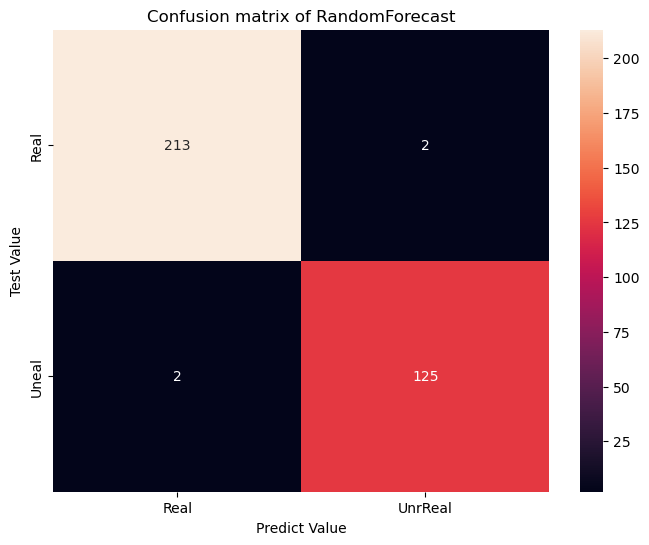

In [48]:
#初始化Random Forecast模型
rf_model = RandomForestClassifier()
# 開始計時
start_time = time.time()
# 模型訓練
rf_model.fit(X_train_scaled, y_train)
# 訓練時間
fit_time = time.time() - start_time
# 開始計時
start_time = time.time()
# 模型預測
y_pred = rf_model.predict(X_test_scaled)
# 預測時間
predict_time = time.time() - start_time
# 評估模型性能
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
xticklabels = ['UnrReal','Real']
yticklabels = ['Uneal','Real']
#混淆矩陣熱圖製作
plt.figure(figsize=(8, 6))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=xticklabels, yticklabels=yticklabels).set_title('Confusion matrix of RandomForecast') # Change title name
plt.xlabel('Predict Value')
plt.ylabel('Test Value')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.savefig(output_dir+'Confusion matrix of RandomForecast.png')
# 顯示結果
print(f"RandomForecast 分類報告：\n {report}")
print(f"訓練時間: {fit_time} 秒")
print(f"預測時間: {predict_time} 秒")

Stacking Esemble Learning 分類報告：
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       127
           1       0.99      0.99      0.99       215

    accuracy                           0.99       342
   macro avg       0.99      0.99      0.99       342
weighted avg       0.99      0.99      0.99       342

訓練時間: 1.1000428199768066 秒
預測時間: 0.010425567626953125 秒


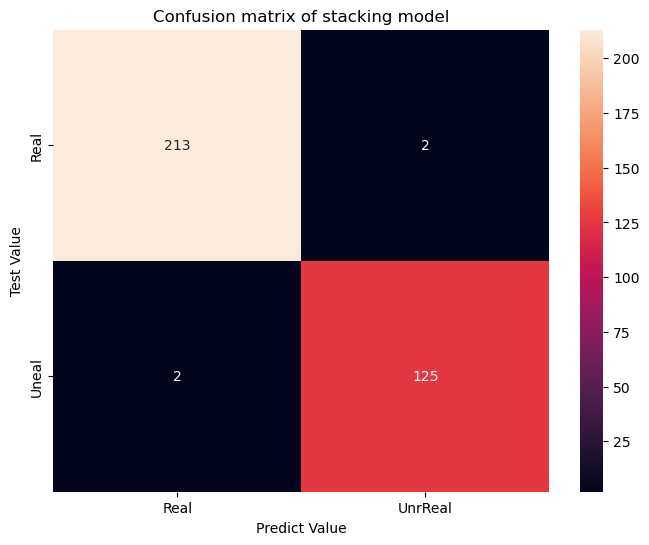

In [49]:
# 初始化 StackingClassifier
stacking_model = StackingClassifier(
  estimators=[('svm', svm_model), ('rf', rf_model)],
  final_estimator=RandomForestClassifier(),  # 第二層模型 (最終模型)
  stack_method='auto',
  # 自動選擇'predict_proba, decision_duction, predict三種中最合適的方式
)
# 開始計時
start_time = time.time()
# 訓練 Stacking 模型
stacking_model.fit(X_train_scaled, y_train)
# 訓練時間
fit_time = time.time() - start_time
# 開始計時
start_time = time.time()
# 模型預測
y_pred_stacking = stacking_model.predict(X_test_scaled)
# 預測時間
predict_time = time.time() - start_time
# 評估 Stacking 模型性能
report_stacking = classification_report(y_test, y_pred_stacking)
cm_stacking = confusion_matrix(y_test, y_pred_stacking)
xticklabels = ['UnrReal','Real']
yticklabels = ['Uneal','Real']
#混淆矩陣熱圖製作
plt.figure(figsize=(8, 6))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=xticklabels, yticklabels=yticklabels).set_title('Confusion matrix of stacking model') # Change title name
plt.xlabel('Predict Value')
plt.ylabel('Test Value')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.savefig('output/Confusion matrix of stacking model.png')
# 顯示結果
print(f"Stacking Esemble Learning 分類報告：\n {report}")
print(f"訓練時間: {fit_time} 秒")
print(f"預測時間: {predict_time} 秒")

In [ ]:
# 保存Random Foreset 模型
joblib.dump(rf_model, 'models/random_forest_model.pkl')

# 保存 scaler (用於特徵縮放)
joblib.dump(scaler, 'models/scaler.pkl')

# Notebook Summary
這份Notebook主要針對臉書社群平台用戶資料與互動行為進行分析，並建立預測模型以辨識用戶的真實性。<br>
此分析是一個簡單的機器學習模型訓練、預測及評估成效，並且包含了資料預處理、探索性分析、模型訓練與測試等步驟。最後儲存訓練好的模型以便後續使用。  

以下是主要步驟與內容：

1. 資料讀入與預處理
從CSV匯入資料並重新命名欄位，接著利用分組中依據各個欄位的概率分佈實施缺漏值遞補，最終確保所有欄位缺漏值皆獲得處理。

2. 探索性分析：
針對所有欄位，分別利用直方圖比較不同“class”（例如Real與UnReal）下的分佈情形，並將圖形輸出至Word文件中以便後續檢視。

3. 模型訓練與評估：
運用經過MinMaxScaler縮放的資料，建立了SVM（多項式核）、隨機森林模型及Stacking融合模型。透過訓練、預測和呈現混淆矩陣（以熱圖形式儲存）以及分類報告（precision、recall、f1-score等）來進行績效評估。

4. 儲存模型：最終將隨機森林模型與縮放器進行儲存，便於部署或後續使用。

## 本專案經過後續的特徵篩選與建構、模型調教，得到一些有趣的發現，跟大家分享：

1. 隨機森林演算法在非真實帳號辨識中展現優異表現，不僅達到99%的高準確率，同時具備卓越的時間效能。
2. 社群互動行為特徵對模型辨識力的重要影響：研究發現，相較於容易被操縱的靜態個人資料特徵(如年齡、生日及自我介紹等)，社群互動行為特徵對於辨識非真實帳號具有更顯著的貢獻。
3. 三項關鍵辨識特徵的實證分析 (based on EDA OUTPUT)
    - 年齡資訊差異(user_age_diff)：真實帳號使用者的年齡資訊通常與其上傳照片相符，而非真實帳號因使用盜用或虛構圖像導致顯著差異
    - 貼文留言平均數量(post_avg_comment)：真實用戶通常維持一定程度的社交互動，而非真實帳號則表現出較低的互動頻率
    - 貼文打卡與情感標記占比(post_act_at_with_feel_ratio)：真實帳號傾向於在貼文中加入地理位置標記及情感表達，非真實帳號則在此類自然社交行為上表現不足
